In [1]:
import pandas as pd
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import spacy
import string
from gensim.models.phrases import Phrases, Phraser
import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import lemmatize
from pprint import pprint
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
cnn_text = pd.read_csv("../data/cnn_text.csv")

In [3]:
cnn_text.head()

,Abstract,Title,clean_text
0,Hypoglycemic events are common and potentially...,Automatic Detection of Hypoglycemic Events Fro...,hypoglycemic event common potentially dangerou...
1,Triaging of outpatient referrals to ophthalmol...,Triaging ophthalmology outpatient referrals wi...,triage outpatient referral ophthalmology servi...
2,Advances in deep learning (DL) have been trans...,Applied Deep Learning in Plastic Surgery: Clas...,advance deep learn dl transformative computer ...
3,A substantial portion of medical data is unstr...,Clinical Data Extraction and Normalization of ...,substantial portion medical datum unstructured...
4,Data used for training of deep learning networ...,Structured report data can be used to develop ...,datum use training deep learning network usual...


In [14]:
stop_words = stopwords.words('english')
print(len(stop_words))
remove_words = ['overall', 'perform','attempts', 'model','use', 'calculating','performance','trainable',
                'data','result','representations','using','limited','used','feature','proposed','evaluate'
                ,'performance','algorithm','lr','ext','respective','respectively', 'accuracy', 'relatively'
                ,'small','challenge','validation','layer','better','three','detection','show','cnn','li', 
                'small','show','development','training','transfer','twos','cnns','pre','auroc','two','method',
                'parameters','segmentation','convolutional', 'neural', 'network', 'show','task','compare',
                'state','study', 'retrospective', 'datum','prediction','art','require', 'focus', 'base',
                'approach', 'paper', 'present', 'fall', 'due', 'recent', 'exponential', 'increase','analysis',
                'analysis','specificity','basis', 'function', 'kernel', 'area', 'curve', 'auc', 'may', 
                'useful','explore', 'two', 'different','test','models','system','deep', 'learning',
                'approach','require','may', 'useful','information', 'basis','obtain','methods','achieve',
                'level','al', 'research', 'grid', 'also','features', 'techniques', 'hard', 'parameter', 
                'sharing', 'cross', 'stitch', 'train', 'word', 'level', 'however','search', 'currently',
                'trained','article','analytic','datasets','fold', 'cross', 'propose','compared','based',
                'classification','results','dataset','multiple', 'time','architecture','end', 'sensitivity', 
                'specificity','proive','representation','input','technique','large','work','improve','layers',
                'set','learn','experiment','achieved','information','machine','offers', 'high','networks',
                'superior', 'classification', 'accuracy', 'for', 'automated', 'coding', 'support', 'aid', 'address',
               'available','https','important','role', 'application','good','rate','field','new','tool',
               'subject','value','map','quality','application','provide','one','mr', 'false','positive','tune','fine',
                'github','com','precision','recall','long','short','gold', 'standard','problem','demonstrate','apply',
                'well','truth','ground','similarity','coefficient','entity','event','cohort','molecular','goal','knowledge',
                'refer','conditional','name','natural','language','metho','processing','nlp','term', 'supplementary']

#identifies and removes duplicates and returns a lits of words
remove_words= list(set(remove_words))
stop_words.extend(remove_words)
print(len(remove_words))
print(len(stop_words))

179
197
376


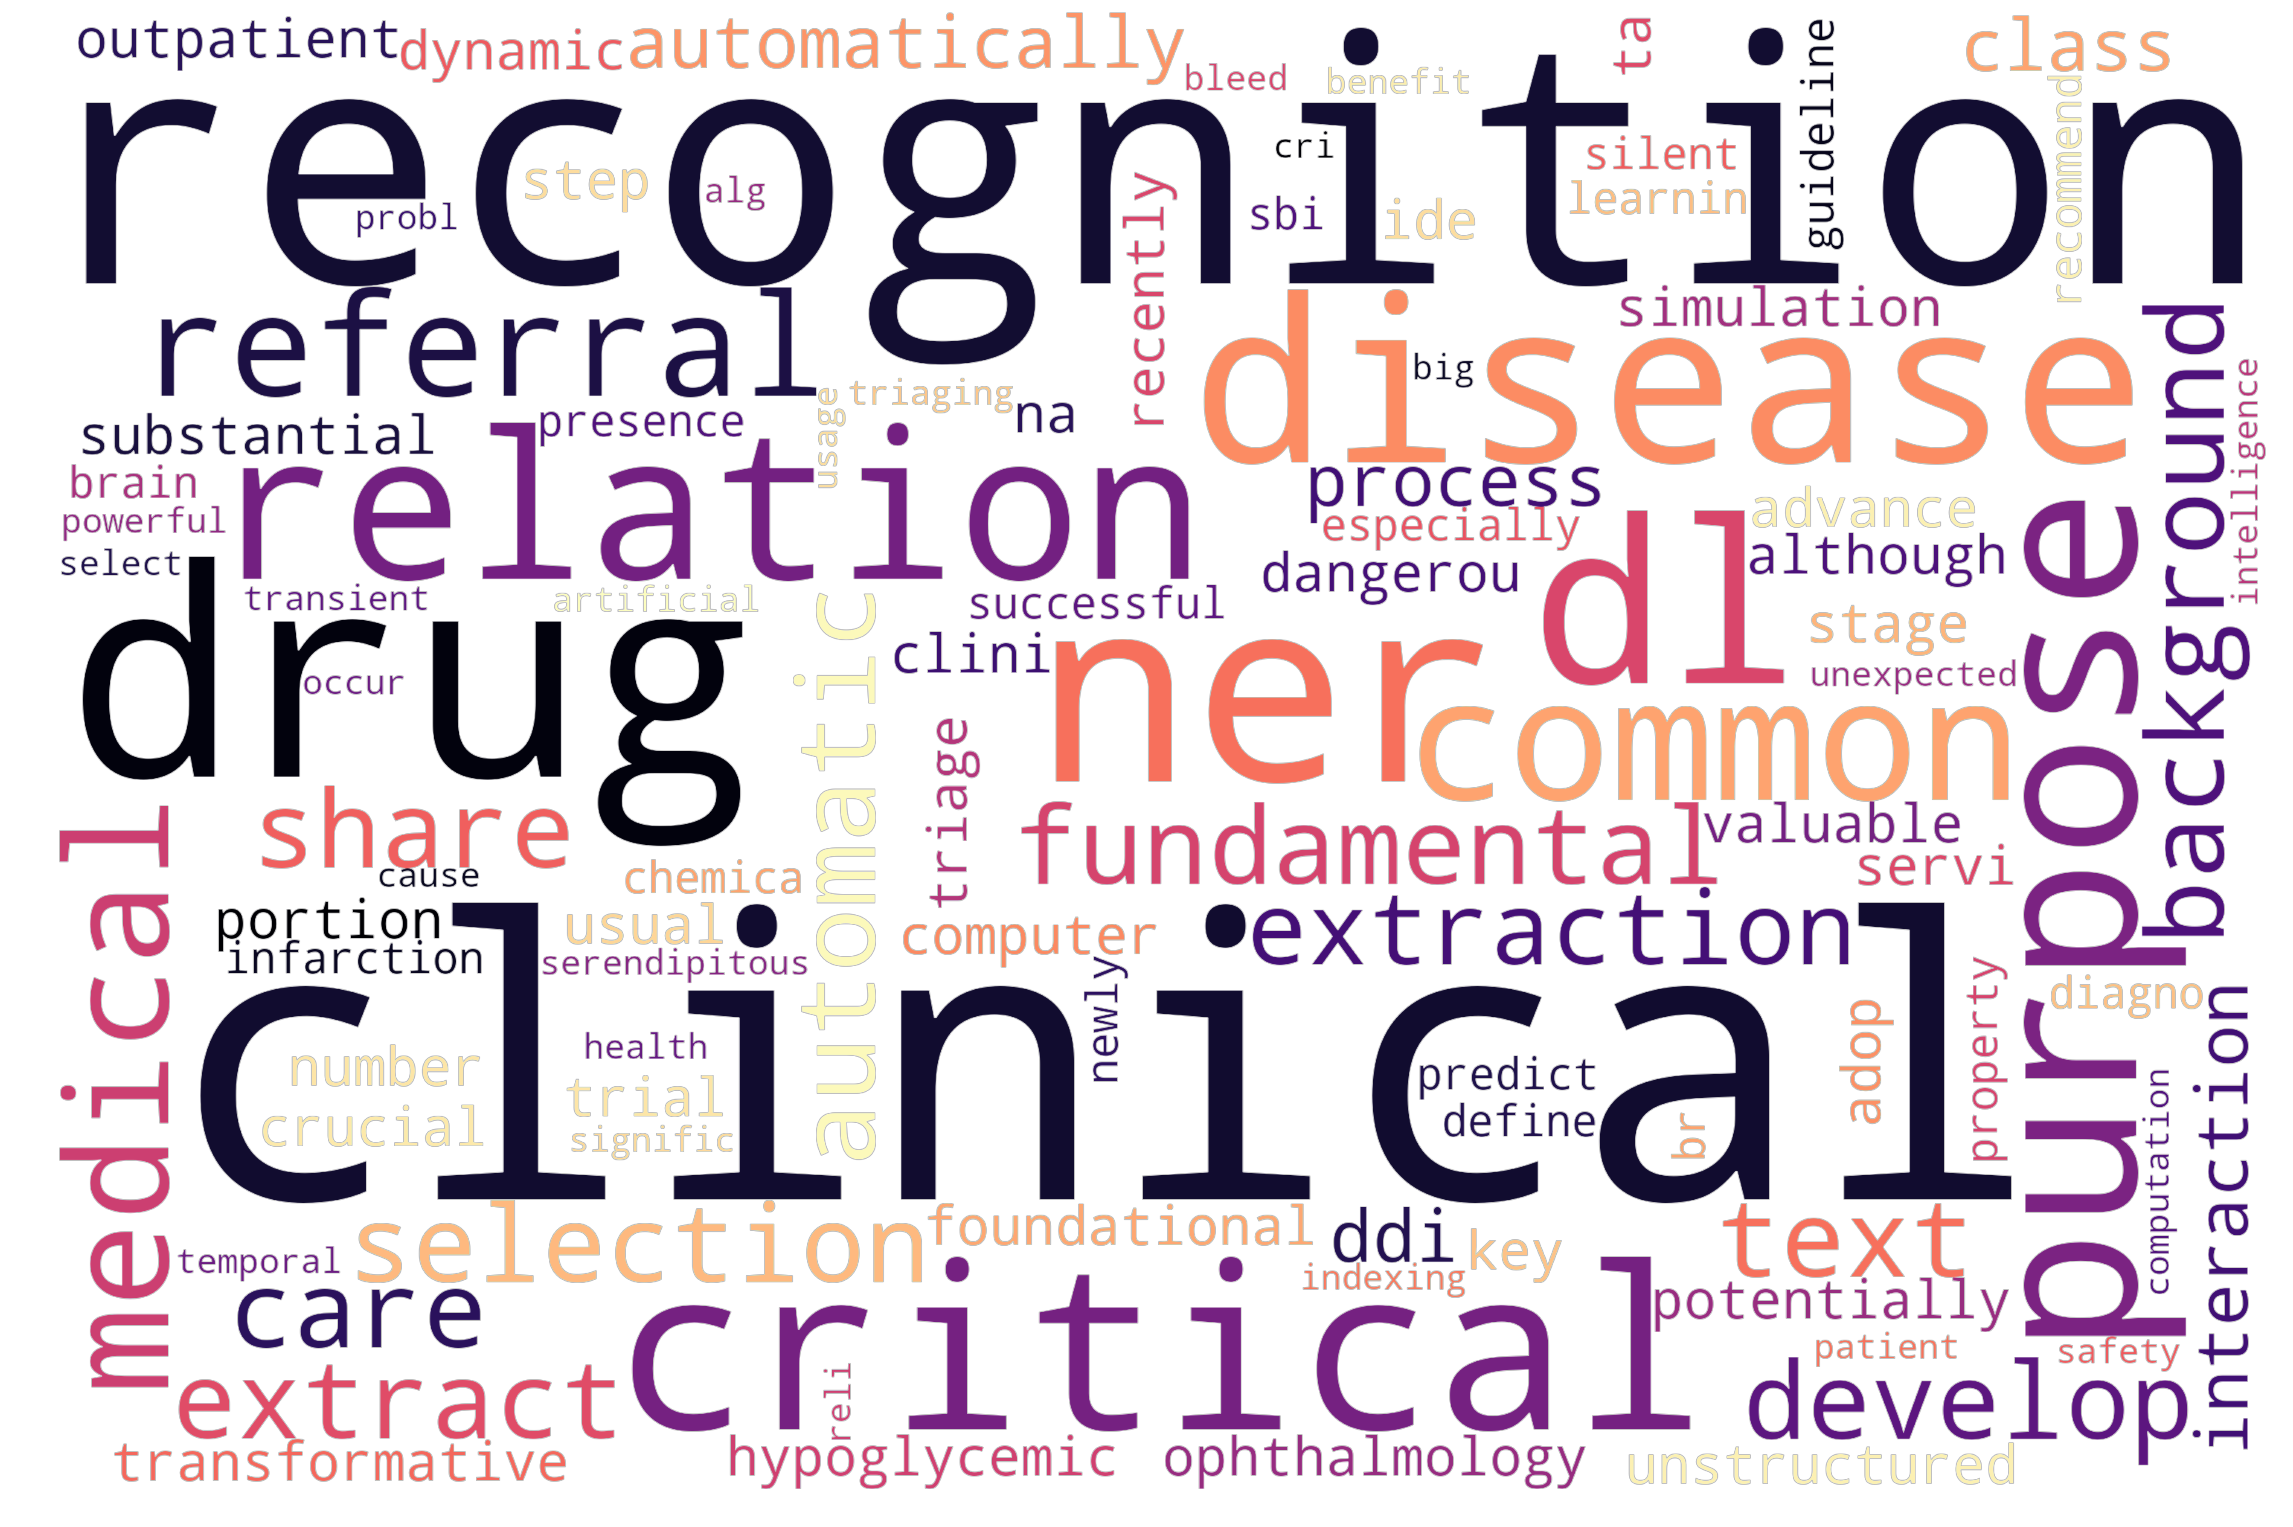

In [15]:
#Word cloud of 100 words in the entire clean text
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color="rgba(255, 255, 255, 0)", mode="RGBA",colormap=plt.cm.magma,
                          stopwords=stop_words,
                          max_words=100,
                           
                          random_state=42,collocations=False
                         ).generate(str(cnn_text.clean_text))

#print(wordcloud)
plt.figure(figsize = (40, 30), edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.savefig("../data/word_cloud.png")
plt.show()



In [16]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
minus_stopwords = remove_stopwords(cnn_text.clean_text)

In [17]:
clean_text = [" ".join(x) for x in minus_stopwords]

In [18]:
def text_to_words(text):
    for sentence in text:
        yield(gensim.utils.simple_preprocess(str(sentence)))  # deacc=True removes punctuations

words_text = list(text_to_words(clean_text))

print(words_text[3])

['substantial', 'portion', 'medical', 'unstructured', 'extract', 'unstructured', 'text', 'barrier', 'advance', 'clinical', 'patient', 'care', 'addition', 'ongoing', 'predominately', 'english', 'whereas', 'inflect', 'non', 'latin', 'alphabet', 'slavic', 'cyrillic', 'alphabet', 'numerous', 'linguistic', 'develop', 'automatically', 'extract', 'biomarker', 'status', 'patient', 'breast', 'cancer', 'oncology', 'center', 'bulgaria', 'dual', 'embedding', 'english', 'bulgarian', 'encode', 'syntactic', 'polarity', 'embedding', 'subsequently', 'align', 'vector', 'space', 'embedding', 'recurrent', 'derive', 'biomarker', 'status', 'estrogen', 'receptor', 'progesterone', 'receptor', 'human', 'epidermal', 'growth', 'factor', 'receptor', 'resolve', 'ambiguity', 'highly', 'variable', 'medical', 'text', 'contain', 'latin', 'cyrillic', 'text', 'final', 'incorporate', 'english', 'bulgarian', 'syntax', 'polarity', 'embedding', 'score', 'estrogen', 'receptor', 'progesterone', 'receptor', 'human', 'epidermal

In [19]:
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
lemmatized_words = lemmatization(words_text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
#clean_text = [" ".join(x) for x in minus_stopwords]

                  Bigram      Freq
0              free text  6.239966
1          clinical note  5.009628
2          clinical text  4.608722
3        computer vision  4.480556
4        recognition ner  4.459707
5            memory lstm  4.208407
6   bioinformatic online  4.171097
7    attention mechanism  4.105451
8    relation extraction  3.767327
9          recurrent rnn  3.661926
10         random forest  3.605572
11     electronic health  3.045275
12         health record  3.045275


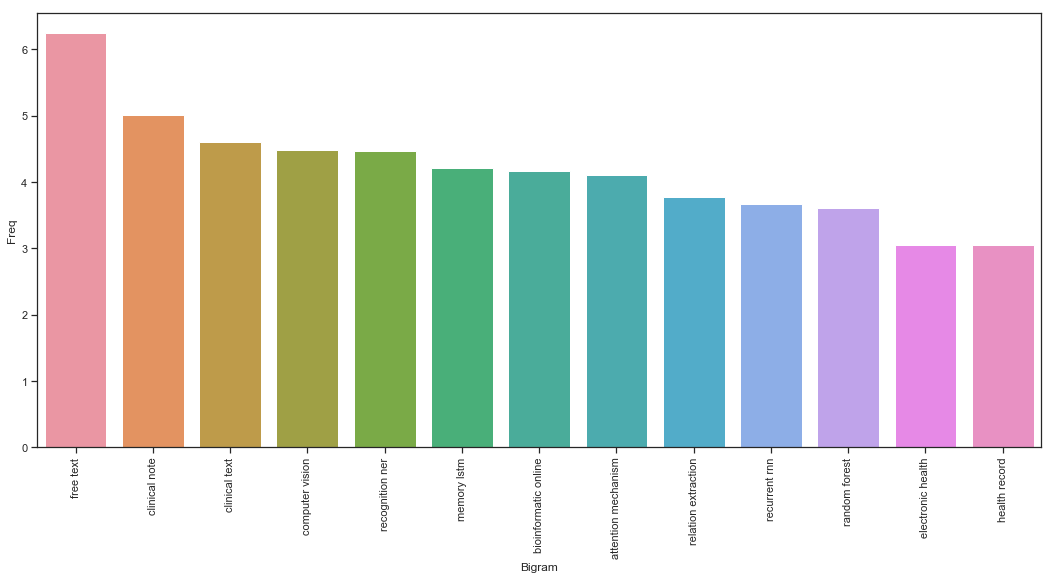

In [21]:
#Most frequently occuring bigrams in the data. plot both bar plot and word cloud of bigrams in the data 
def top_bi_grams(clean_text, n=None):
    clean_text = [" ".join(x) for x in lemmatized_words]
    vectorizer = TfidfVectorizer(ngram_range = (2,2), min_df = 5,stop_words=stop_words).fit(clean_text)
    bows = vectorizer.transform(clean_text)
    sumwords = bows.sum(axis=0) 
    words_freq = [(word, sumwords[0, idx]) for word, idx in     
                  vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top_bigrams = top_bi_grams(clean_text, n=50)
top_bigrams_df = pd.DataFrame(top_bigrams)
top_bigrams_df.columns=["Bigram", "Freq"]
print(top_bigrams_df)

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(18,8)}, style ='white' )
sns.set_style("ticks")

h=sns.barplot(x="Bigram", y="Freq", data=top_bigrams_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90);

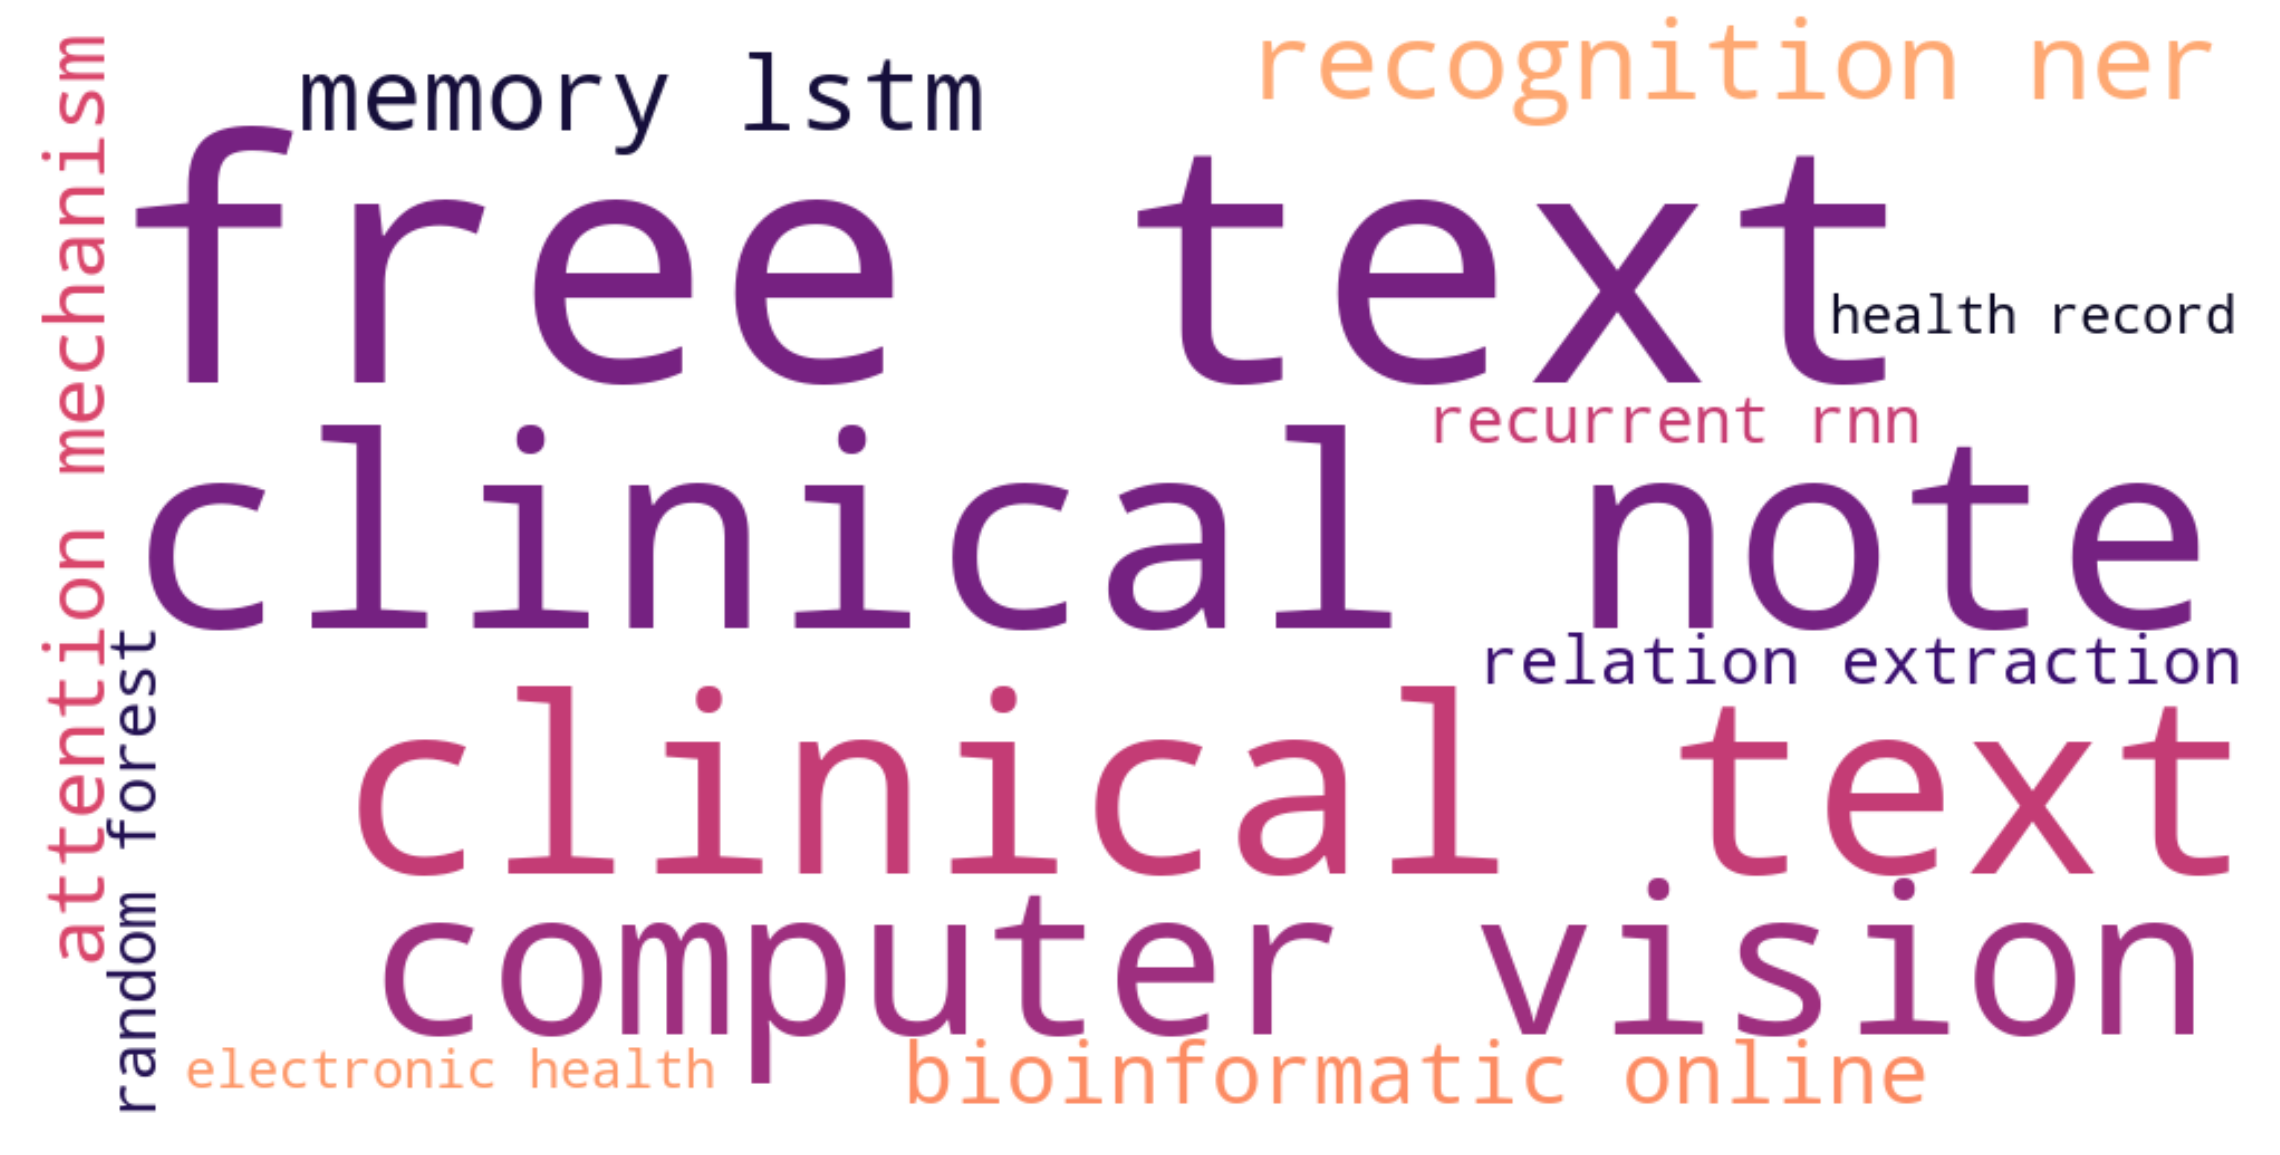

In [22]:
bigrams = {}
for w, x in top_bigrams_df.values:
    bigrams[w] = x
wordcloud = WordCloud(width = 1000,
    height = 500,background_color="white",colormap=plt.cm.magma,margin=5,
                     min_word_length =2, relative_scaling=1, collocations=False)
wordcloud.generate_from_frequencies(bigrams)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../data/word_cloud_cnn_text.png", bbox_inches='tight')
plt.show()

In [40]:
bigram = Phrases(lemmatized_words, min_count=1, threshold=100)
trigram = Phrases(lemmatized_words, min_count=1, threshold=100)
bigrams_mod = Phraser(bigram)
trigrams_mod = Phraser(trigram)

In [41]:
def bigrams(texts):
    return [bigrams_mod[doc] for doc in texts]
words_bigrams = bigrams(lemmatized_words)

def trigrams(texts):
    return [trigrams_mod[doc] for doc in texts]
words_trigrams = trigrams(lemmatized_words)

In [42]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(words_bigrams)


# Create Corpus
texts = words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])


[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 4), (25, 3), (26, 2), (27, 1), (28, 3), (29, 2), (30, 1), (31, 4), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1)], [(6, 1), (11, 1), (14, 2), (31, 1), (37, 1), (48, 1), (49, 1), (50, 3), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 6), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 5), (73, 1), (74, 1), (75, 2), (76, 2), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 4), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 1), (96, 3), (97, 2), (98, 1), (99, 1)]]


In [44]:
id2word[75]

'ophthalmology'

In [69]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=18, 
                     random_state=100,
                     update_every=1,
                     chunksize=1000,
                     passes=100,
                     alpha='auto',
                     per_word_topics=True)

In [70]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"text" + 0.015*"embed" + 0.015*"clinical" + 0.015*"paradigm" + '
  '0.013*"medical" + 0.011*"compound" + 0.011*"chinese_emrs" + 0.011*"protein" '
  '+ 0.009*"score" + 0.009*"cpi"'),
 (1,
  '0.024*"medical_subdomain" + 0.024*"classifier" + 0.024*"clinical" + '
  '0.018*"embed" + 0.015*"bind" + 0.012*"note" + 0.012*"hla" + 0.011*"medical" '
  '+ 0.009*"score" + 0.009*"distribute"'),
 (2,
  '0.024*"image" + 0.024*"diagnosis" + 0.018*"radiology" + 0.018*"clinical" + '
  '0.012*"outcome" + 0.012*"acute_neurologic" + 0.012*"treatment" + '
  '0.012*"primarily" + 0.012*"head" + 0.012*"rapid"'),
 (3,
  '0.015*"disease" + 0.015*"share" + 0.015*"predict" + 0.015*"dl" + '
  '0.012*"text" + 0.012*"score" + 0.012*"image" + 0.012*"rhinonet" + '
  '0.012*"plastic_surgery" + 0.009*"identify"'),
 (4,
  '0.034*"lstm" + 0.024*"brain" + 0.020*"clinical" + 0.017*"find" + '
  '0.017*"lstm_highway" + 0.017*"selection" + 0.017*"score" + 0.014*"report" + '
  '0.014*"pefinder" + 0.010*"sentence"'),

In [71]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.1524988287830835

Coherence Score:  0.44188171409142596


In [72]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

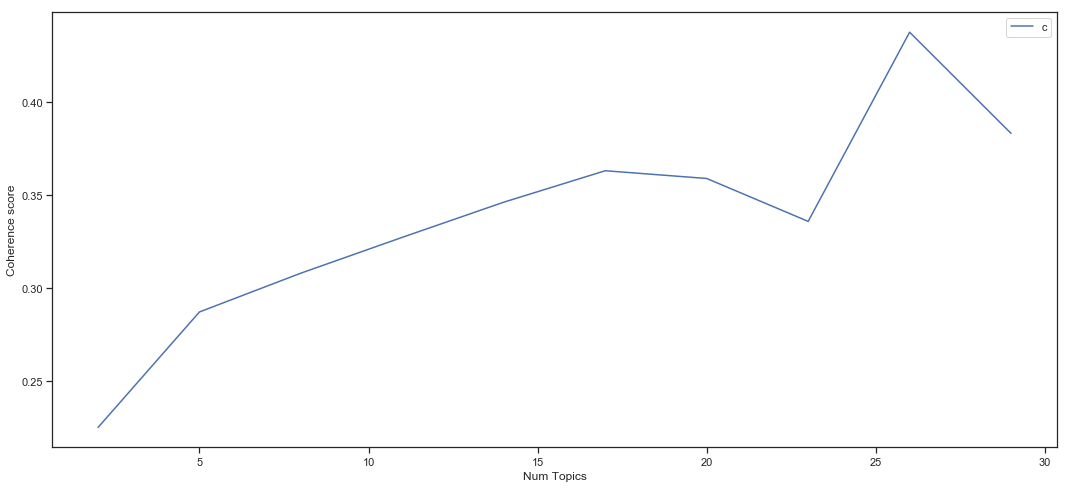

In [73]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words_bigrams, start=2, limit=30, step=3)
# Show graph

limit=30; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [74]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.118807  0.026209       1        1  16.553127
0      0.056241 -0.061224       2        1   9.585388
6      0.102084 -0.097063       3        1   9.212696
15     0.069221  0.231748       4        1   8.148300
7      0.090314  0.037034       5        1   6.904984
13    -0.098094 -0.069201       6        1   6.778208
12    -0.094034  0.025975       7        1   5.770305
11     0.085962 -0.051140       8        1   5.425920
3     -0.002543  0.005016       9        1   5.301971
1      0.077942 -0.021083      10        1   5.212602
4      0.006126  0.057034      11        1   4.435836
16     0.035652 -0.087352      12        1   4.140123
14    -0.149425  0.026573      13        1   3.170947
17    -0.021578  0.003894      14        1   2.811862
5     -0.148223  0.008167      15        1   2.223160
2     -0.069799  0.005467      16        1   1.716143
9     -0.039793 -0.010243      17        1   1.526000
8     -0.018858 -0.029812      18        1   1.082420, topic_info=    Category       Freq          Term      Total  loglift  logprob
242  Default  40.000000        report  40.000000  30.0000  30.0000
166  Default  64.000000      clinical  64.000000  29.0000  29.0000
184  Default  33.000000       medical  33.000000  28.0000  28.0000
781  Default  14.000000         bleed  14.000000  27.0000  27.0000
299  Default  15.000000           ner  15.000000  26.0000  26.0000
..       ...        ...           ...        ...      ...      ...
464  Topic18   0.389430  experimental  10.670130   1.2155  -4.8796
549  Topic18   0.389430       disease  11.786074   1.1160  -4.8796
61   Topic18   0.758375       extract  24.069605   1.0684  -4.2131
681  Topic18   0.758375          rule  25.000898   1.0305  -4.2131
166  Topic18   1.127318      clinical  64.708733   0.4759  -3.8167

[1131 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1176      8  0.917512    abstract
961      11  0.717130    abundant
1144      7  0.518951  accelerate
1144     16  0.518951  accelerate
1045     13  0.757267      access
...     ...       ...         ...
1460      3  0.657194     writing
1571     10  0.700763         xhx
1274      7  0.691594         yet
47        1  0.388279       yield
47       10  0.388279       yield

[1750 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 1, 7, 16, 8, 14, 13, 12, 4, 2, 5, 17, 15, 18, 6, 3, 10, 9])

In [75]:
pyLDAvis.save_html(vis, '../data/lda_text.html')